# Importar Librerías

In [54]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic


# -------------
import warnings

# Desactivar las advertencias de DeprecationWarning
warnings.filterwarnings("ignore")

# Importar funciones personalizadas

In [55]:
%run pandas-missing-extension.ipynb

# Problemática de valores faltantes


## El problema de trabajar con valores faltantes

In [56]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df.head()

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973


In [57]:
airquality_df.isnull().sum()

ozone      37
solar_r     7
wind        0
temp        0
month       0
day         0
year        0
dtype: int64

Intentaremos predecir valores de temperatura, en base a datos de las columnas "ozone" y "solar_r". Nos daremos cuenta que si os estimara valores y correlación y no tendra en cuenta los valores NaN

In [58]:
(
    smf.ols(
        formula = "temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Mon, 15 Jan 2024",Prob (F-statistic):,2.93e-18
Time:,16:46:31,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


| Concepto                              | Valor    | Descripción                                               |
|---------------------------------------|----------|-----------------------------------------------------------|
| **Dep. Variable**                    | temp     | Variable que estás tratando de predecir.                   |
| **R-squared**                        | 0.488    | Proporción de la variabilidad explicada por el modelo.     |
| **Adj. R-squared**                   | 0.483    | Similar a R², ajustado para el número de predictores.     |
| **F-statistic**                      | 108.5    | Evalúa si el modelo en su conjunto es significativo.      |
| **Prob (F-statistic)**               | 2.93e-18 | Valor p asociado con la estadística F.                     |
| **No. Observations**                 | 116      | Cantidad de datos en el conjunto.                          |
| **Df Residuals**                     | 114      | Grados de libertad restantes después de ajustar el modelo.|
| **Df Model**                         | 1        | Número de parámetros estimados en el modelo.               |
| **Covariance Type**                  | nonrobust | Indica que los estadísticos no están ajustados.           |





In [59]:
(
    smf.ols( # Crea un objeto de modelo de regresión lineal ordinaria (OLS) usando el módulo statsmodels.formula.api.
        formula = "temp ~ ozone + solar_r", #Especifica la fórmula del modelo de regresión. En este caso, se está modelando la variable dependiente temp en función de las variables independientes ozone y solar_r.
        data = airquality_df
    )
    .fit() # Ajusta el modelo a los datos proporcionados en el DataFrame. Retorna un objeto de resultados que contiene información sobre el ajuste del modelo.
    .summary()
    
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     52.07
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           1.47e-16
Time:                        16:46:31   Log-Likelihood:                -369.78
No. Observations:                 111   AIC:                             745.6
Df Residuals:                     108   BIC:                             753.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.4971      1.528     44.814      0.000      65.467      71.527
ozone          0.1943      0.021      9.262      0.000       0.153       0.236
solar_r        0.0060      0.008      0.789      0.432      -0.009       0.021
==============================================================================
Omnibus:                        7.636   Durbin-Watson:                   1.151
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.932
Skew:                          -0.653   Prob(JB):                       0.0189
Kurtosis:                       2.917   Cond. No.                         494.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Reto: Datos de supervivientes

In [60]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data


In [61]:
survival_df.assign(
            case=lambda df: df.index,
            # Crea una nueva columna "n_missing" que cuenta la cantidad de valores faltantes en cada caso.
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            # Crea una nueva columna "pct_missing" que calcula el porcentaje de valores faltantes en cada caso.
            # Divide el recuento de valores faltantes entre el número total de columnas y multiplica por 100.
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        ).sort_values(by="pct_missing", ascending=False)[
            # Selecciona las columnas relevantes del DataFrame resultante.
            ["case", "n_missing", "pct_missing"]
        ]

,case,n_missing,pct_missing
1975,1975,2,15.384615
5583,5583,2,15.384615
2143,2143,2,15.384615
5707,5707,2,15.384615
2120,2120,2,15.384615
...,...,...,...
5971,5971,0,0.000000
1863,1863,0,0.000000
1865,1865,0,0.000000
5963,5963,0,0.000000


In [62]:
survival_df.isnull().sum()

age              0
sex              0
sample.yr        0
kappa            0
lambda           0
flc.grp          0
creatinine    1350
mgus             0
futime           0
death            0
chapter       5705
dtype: int64

In [63]:
survival_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,7874,0.000000
1,sex,0,7874,0.000000
2,sample.yr,0,7874,0.000000
3,kappa,0,7874,0.000000
4,lambda,0,7874,0.000000
5,flc.grp,0,7874,0.000000
6,creatinine,1350,7874,17.145034
7,mgus,0,7874,0.000000
8,futime,0,7874,0.000000
9,death,0,7874,0.000000


<Axes: >

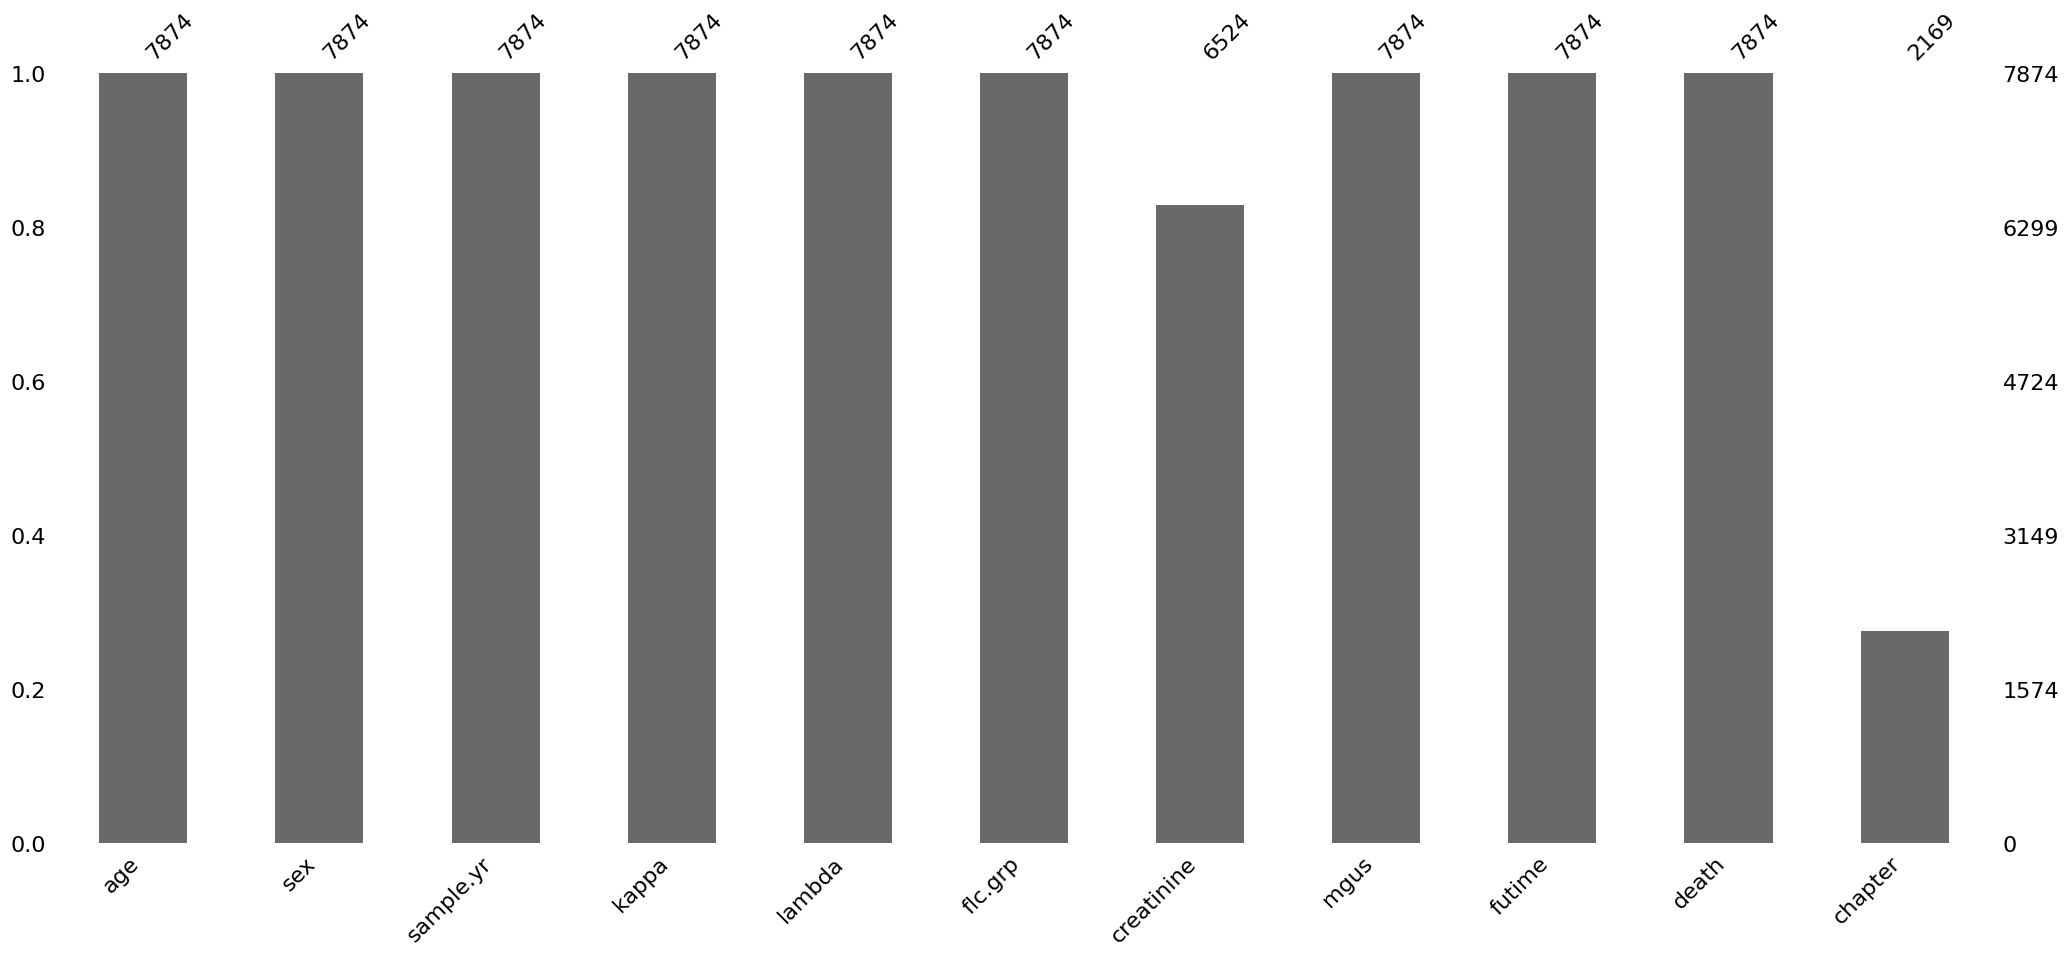

In [64]:
missingno.bar(survival_df)

In [65]:
survival_df.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory


In [66]:
survival_df.rename(columns={"flc.grp":"flc_grp"})

,age,sex,sample.yr,kappa,lambda,flc_grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [67]:
(
    smf.ols(
        formula = "creatinine ~  chapter",
        data  = survival_df 
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,creatinine,R-squared:,0.069
Model:,OLS,Adj. R-squared:,0.061
Method:,Least Squares,F-statistic:,9.560
Date:,"Mon, 15 Jan 2024",Prob (F-statistic):,3.93e-22
Time:,16:46:34,Log-Likelihood:,-1673.6
No. Observations:,1962,AIC:,3379.
Df Residuals:,1946,BIC:,3469.
Df Model:,15,,
Covariance Type:,nonrobust,,


## Preparando datos: National Health and Nutrition Examination survey

El dataset de tiene 8366 filas y 197 columnas. Para un totla de datos de 1648102
<class 'pandas.core.frame.DataFrame'>
Index: 8187 entries, 93703.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   height                    5488 non-null   float64
 1   weight                    5553 non-null   float64
 2   general_health_condition  5797 non-null   object 
 3   total_cholesterol         6565 non-null   float64
 4   pulse                     6570 non-null   float64
 5   diebetes                  8187 non-null   int64  
 6   age                       8187 non-null   float64
 7   gender                    8187 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 575.6+ KB


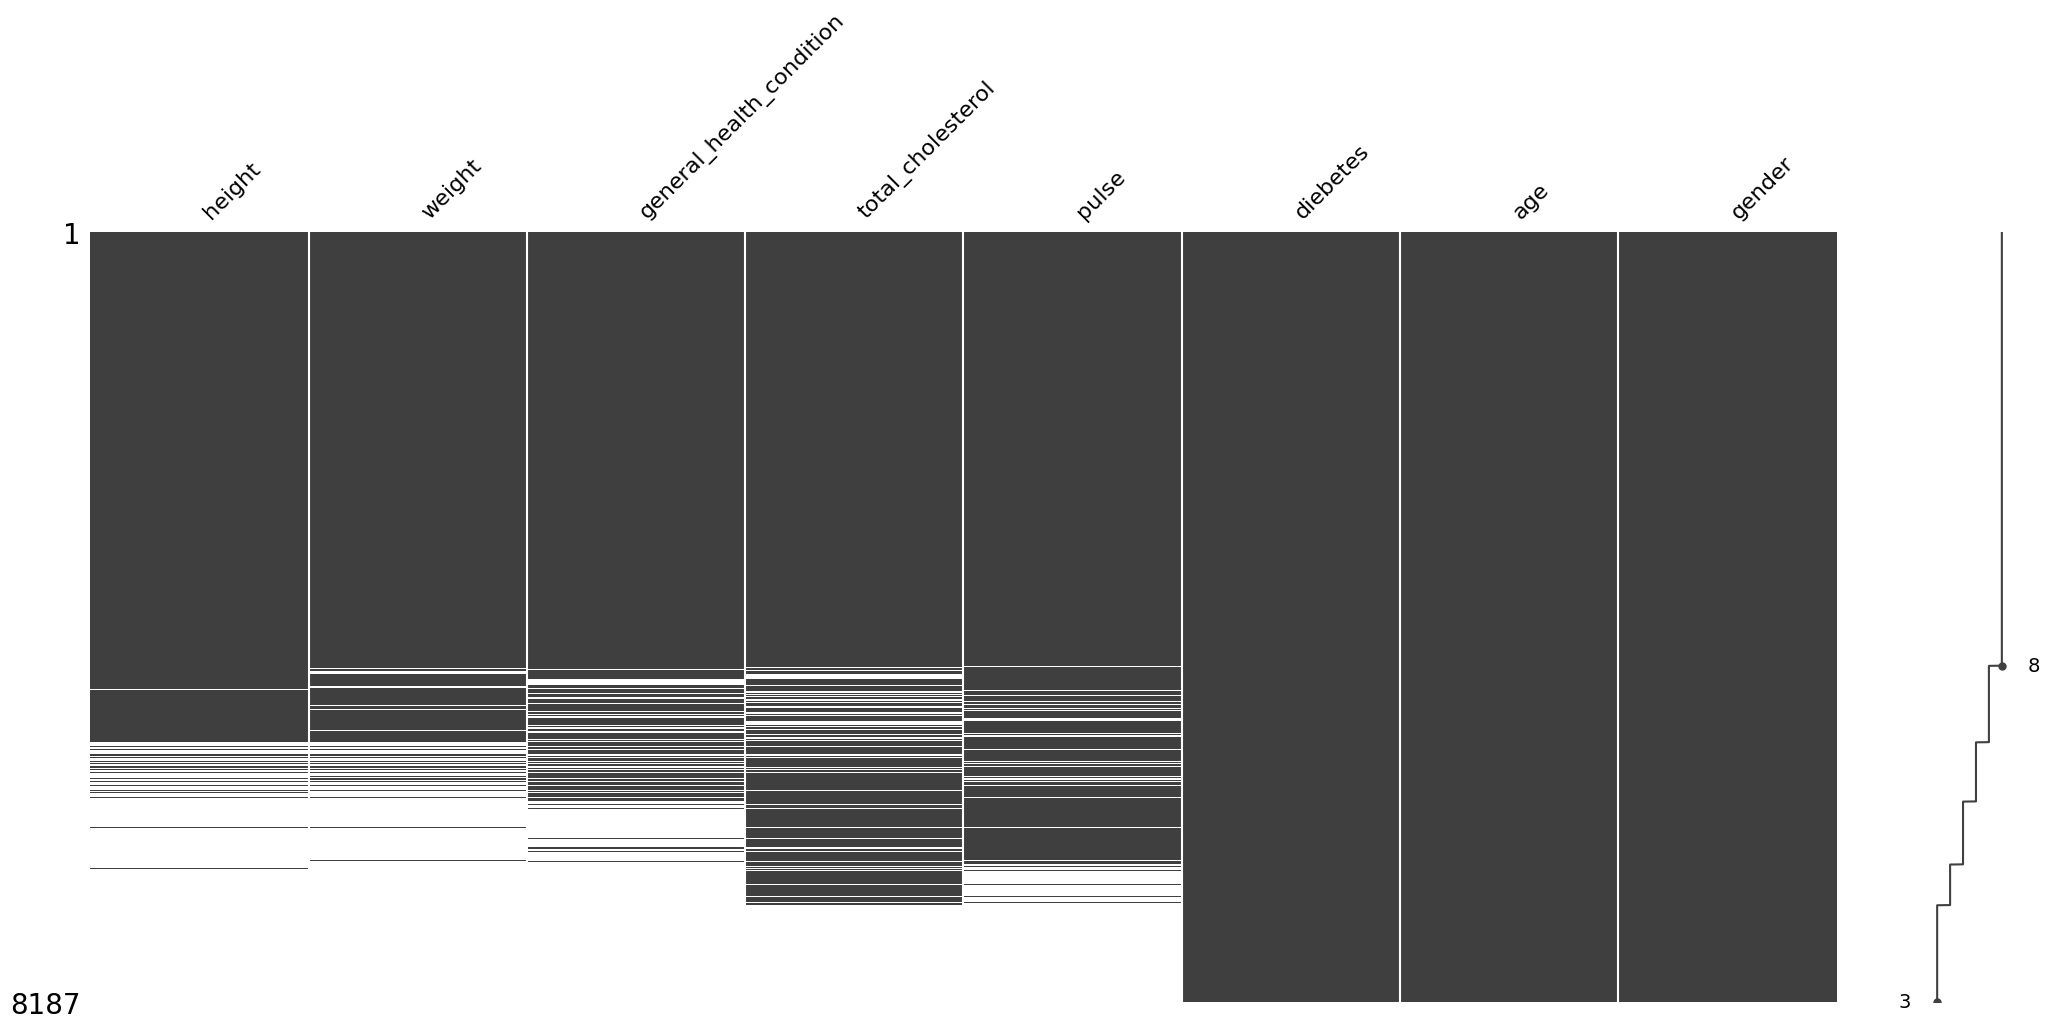

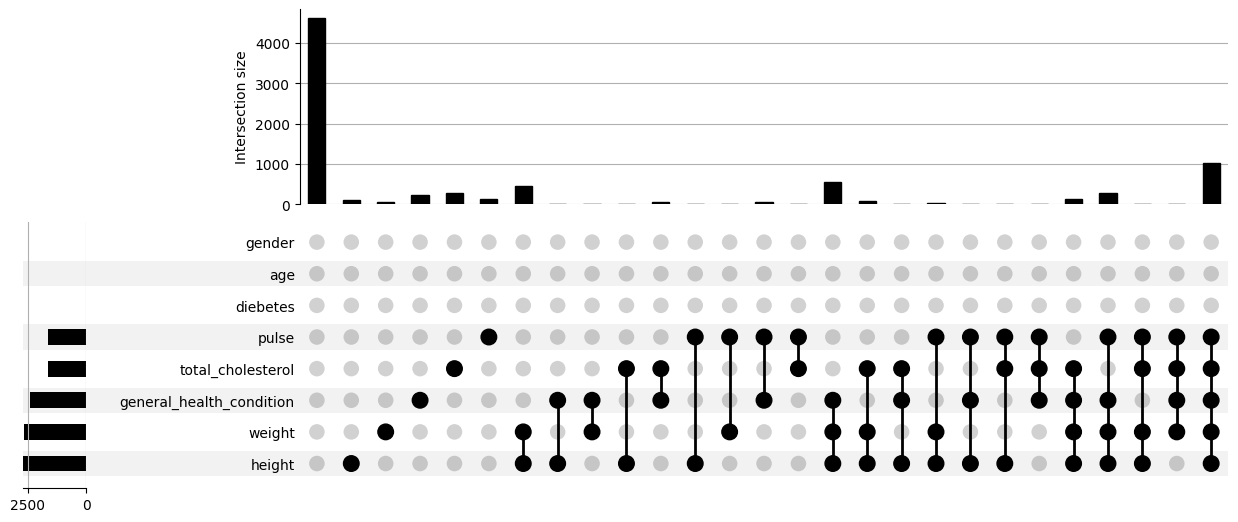

El dataset resultante, después de eliminar algunos datos faltantes es de 7157 columnas y 8 filas. Para un totla de datos de 57256


In [68]:
%run download_data_and_load_it.ipynb

## Implicaciones de los distintos tipos de valores faltantes

### Evaluación del mecanismo de valores faltantes por prueba de $t-test$

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li><code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.
        </li>
        <li><code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
        <li><code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
    </ul>
    </p>
</div>

In [69]:
nhanes_df.head()

,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


In [70]:
opccion_1,opccion_2 = nhanes_df.select_columns ( "gender", "weight").transform_column("weight",lambda x : x.isnull(),elementwise = False).groupby("gender").weight



In [71]:
female_weight, male_weight = (
    nhanes_df
    .select_columns ( "gender", "weight")
    .transform_column(
        "weight",
        lambda x : x.isnull(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df : (
            df.get_group("Female"),
            df.get_group("Male")

        )
    )
)
# Prueba estadistica para saber si existe o no

scipy.stats.ttest_ind(
    a = female_weight,
    b= male_weight,
    alternative = "two-sided"
)

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

## Amplía tu conjunto de herramientas para explorar valores faltantes

In [72]:
def missing_mosaic_plot(column_category_1,column_category_2,target_column,fig_size_x= 10,fig_size_y=10):
    fig, ax = plt.subplots(figsize = (fig_size_x,fig_size_y))
    return (
        nhanes_df
        .select_columns(column_category_1, column_category_2,target_column)
        .assign(
        weight = lambda df_1 : df_1.weight.isna().replace([True, False], ["Missing", "Not Missing"])
    )
    .groupby(
        [column_category_x, column_category_y, target_column],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df_1 : mosaic(
            data = df_1,
            properties = lambda key : {"color": "r" if "Missing" in key else "#dcdcdc"},
            horizontal = True,
            axes_label = True,
            title = f"Gráfico de mosaico, Missing {target_column}",
            labelizer = lambda key : "",
            ax = ax
        )
    )
    );
    

In [73]:
nhanes_df.general_health_condition

SEQN
93705.0          Good
93706.0     Very good
93707.0          Good
93709.0           NaN
93711.0     Very good
              ...    
102949.0    Excellent
102953.0      Fair or
102954.0         Good
102955.0    Very good
102956.0         Good
Name: general_health_condition, Length: 7157, dtype: object

NameError: name 'column_category_x' is not defined

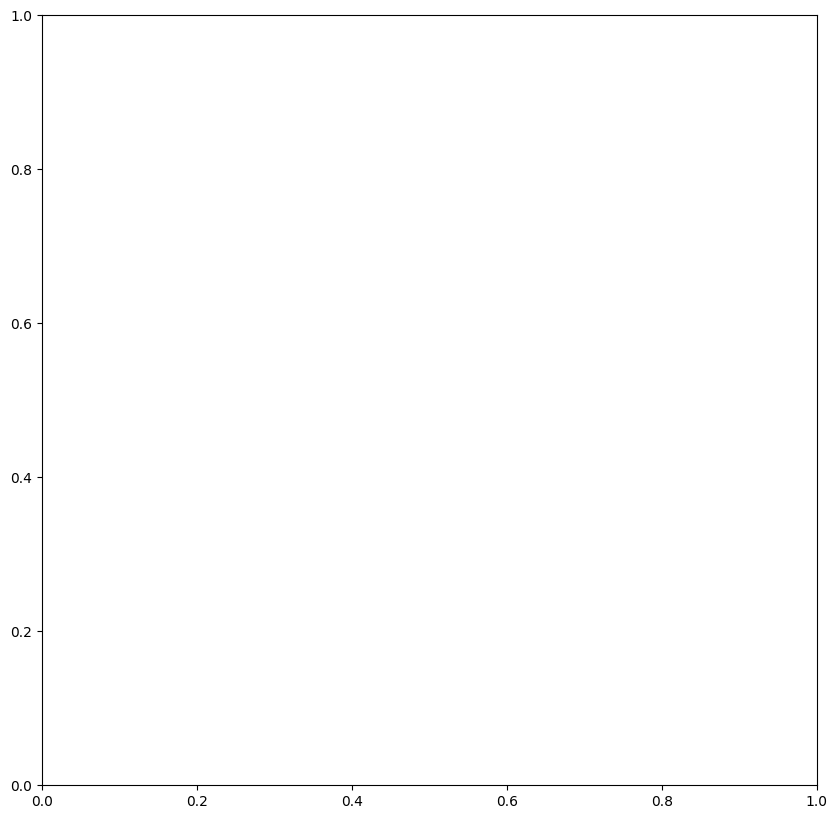

In [74]:
missing_mosaic_plot(column_category_1="general_health_condition",column_category_2="weight",target_column="gender")

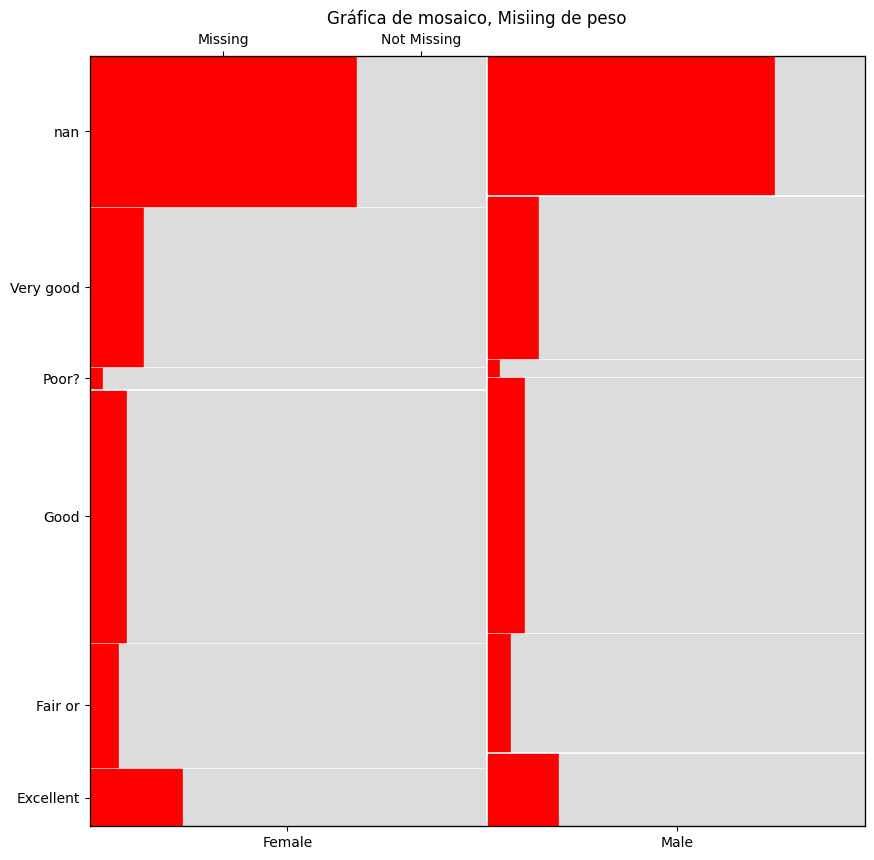

In [75]:
fig, ax = plt.subplots(figsize = (10,10))
(
    nhanes_df
    .select_columns("weight", "general_health_condition","gender")
    .assign(
        weight = lambda df : df.weight.isna().replace([True, False], ["Missing", "Not Missing"])
    )
    .groupby(
        ["gender", "general_health_condition","weight"],
        dropna = False, # no elimine valores faltantes
        as_index = True
    )
    .size()
    .pipe( 
        lambda df: mosaic(
            data = df,
            properties = lambda key : {"color": "r" if  "Missing" in key else "#dcdcdc"},
            horizontal = True,
            axes_label = True,
            title  = "Gráfica de mosaico, Misiing de peso",
            labelizer  = lambda key: "",
            ax = ax
        )
    )
);

## Tratamiento de variables categóricas para imputación: codificación ordinal

In [76]:
nhanes_transformed_df = nhanes_df.copy(deep= True)

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li>Una codificación ordinal implica mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
        </li>
    </ul>
    </p>
</div>

*Ejemplo*
<br><br>
Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal

In [77]:
encoder = sklearn.preprocessing.OrdinalEncoder() # Se crea para poder pasar algo con texto y el lo pasa a numero
X =[["Male"],["Female"],["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [78]:
encoder.fit_transform(X) # aca en parenticis se pasa la varaible a transformar

array([[1.],
       [0.],
       [0.]])

In [79]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [80]:
encoder.inverse_transform([[1],[0],[1]])

array([['Male'],
       ['Female'],
       ['Male']], dtype=object)

### Aplicando la codificación ordinal a todas tus variables categóricas


In [81]:
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

In [82]:
# funcion de skylearn para transforman datos

categorical_transformer  = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
     remainder="passthrough"
)

In [83]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index #Traemos los index del dataframe original
    )
    .rename_columns(
        function = lambda x : x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x : x.removeprefix("remainder__")
    )

)

## One Hot Encoding

In [84]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)
nhanes_transformed_df2

,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


### pandas.get_dummies() vs skelearn.preprocessing.OneHotEncoder()



 <code>pandas.get_dummies()</code>

In [85]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
#   .head(10)
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


<code> skelear.preprocessing.OneHotEncoder()</code>

In [86]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder= "passthrough"
)

In [87]:

nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diebetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [88]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)
     

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [89]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0,0,1,0,0,0]]
    )
)

array([['Good']], dtype=object)

**Ordinal encoding**

- 5-10-20 categories → Ordinal encoding

**One Hot Encoding**

- 100-1000-2000-3000 categories → One Hot Encoding

**Ordinal Encoder:**
El OrdinalEncoder se utiliza cuando existe un orden o jerarquía natural entre las categorías de una variable categórica. Esto significa que las categorías tienen una relación de orden y se pueden asignar valores numéricos que reflejen este orden. Algunos ejemplos de variables categóricas donde se puede aplicar el OrdinalEncoder son:
- Niveles de educación: como "Primaria", "Secundaria", "Universidad", donde hay un orden lógico de menor a mayor nivel educativo.
- Evaluaciones de rendimiento: como "Bajo", "Medio", "Alto", donde hay una escala ordinal de bajo a alto rendimiento.

**One-Hot Encoder:**
El OneHotEncoder se utiliza cuando no existe un orden o jerarquía natural entre las categorías de una variable categórica, y se desea crear variables binarias para cada categoría. Esto permite representar cada categoría como una columna independiente, donde un valor de 1 indica la presencia de esa categoría y un valor de 0 indica la ausencia. Algunos ejemplos de variables categóricas donde se puede aplicar el OneHotEncoder son:
- Colores: como "Rojo", "Verde", "Azul", donde cada color se representa como una columna separada en el conjunto de datos codificado en caliente.
- Países: como "Estados Unidos", "Canadá", "México", donde cada país se representa como una columna separada indicando su presencia o ausencia.



# Imputación basada en el donante

## Imputación por media, mediana y moda



<div style="text-align:center;">
    <img src="../Image/imputaciones.png" alt="MiImagen" width="60%">
</div>

### Imputación de un único valor (media, mediana, moda)

In [90]:
nhanes_df.columns

Index(['height', 'weight', 'general_health_condition', 'total_cholesterol',
       'pulse', 'diebetes', 'age', 'gender'],
      dtype='object')

In [91]:
nhanes_df.head(5)

,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


In [92]:
(
    nhanes_df
    # Janitor
    .transform_column(
        "height",
        lambda x : x.fillna(x.mean()), #moda o mediana
        elementwise = False
    )
    .height.mean()
)

66.25655976676386

In [93]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
)

,height,weight,height_imp,weight_imp
SEQN,,,,
93705.0,63.0,165.0,False,False
93706.0,68.0,145.0,False,False
93707.0,NaN,NaN,True,True
93709.0,62.0,200.0,False,False
93711.0,69.0,142.0,False,False
...,...,...,...,...
102949.0,72.0,180.0,False,False
102953.0,65.0,218.0,False,False
102954.0,66.0,150.0,False,False


<Axes: xlabel='height', ylabel='weight'>

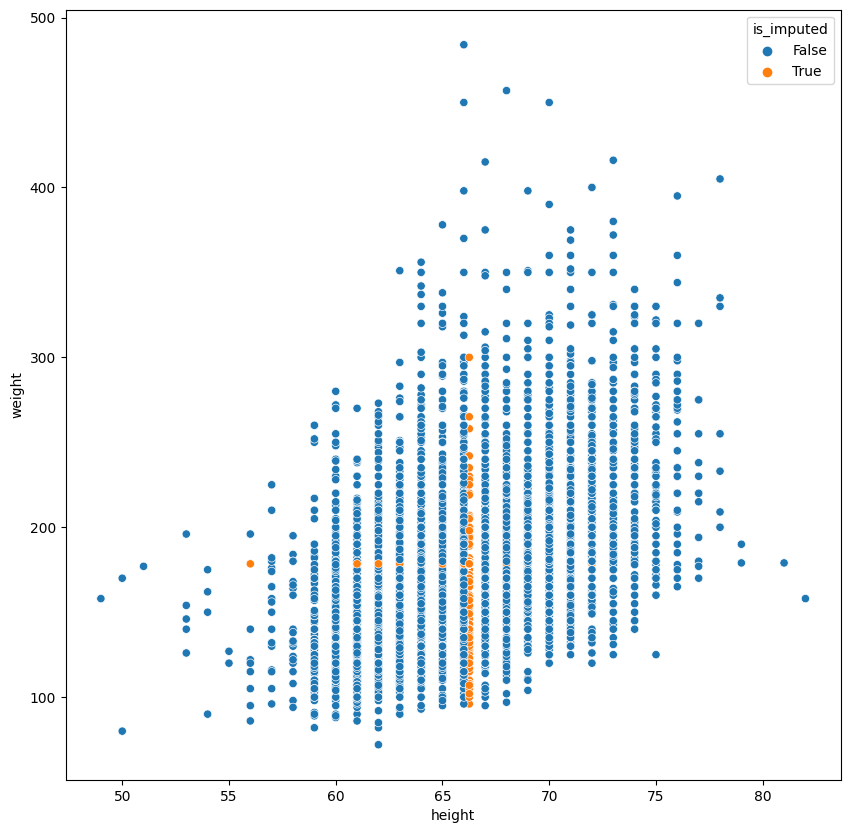

In [94]:
plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

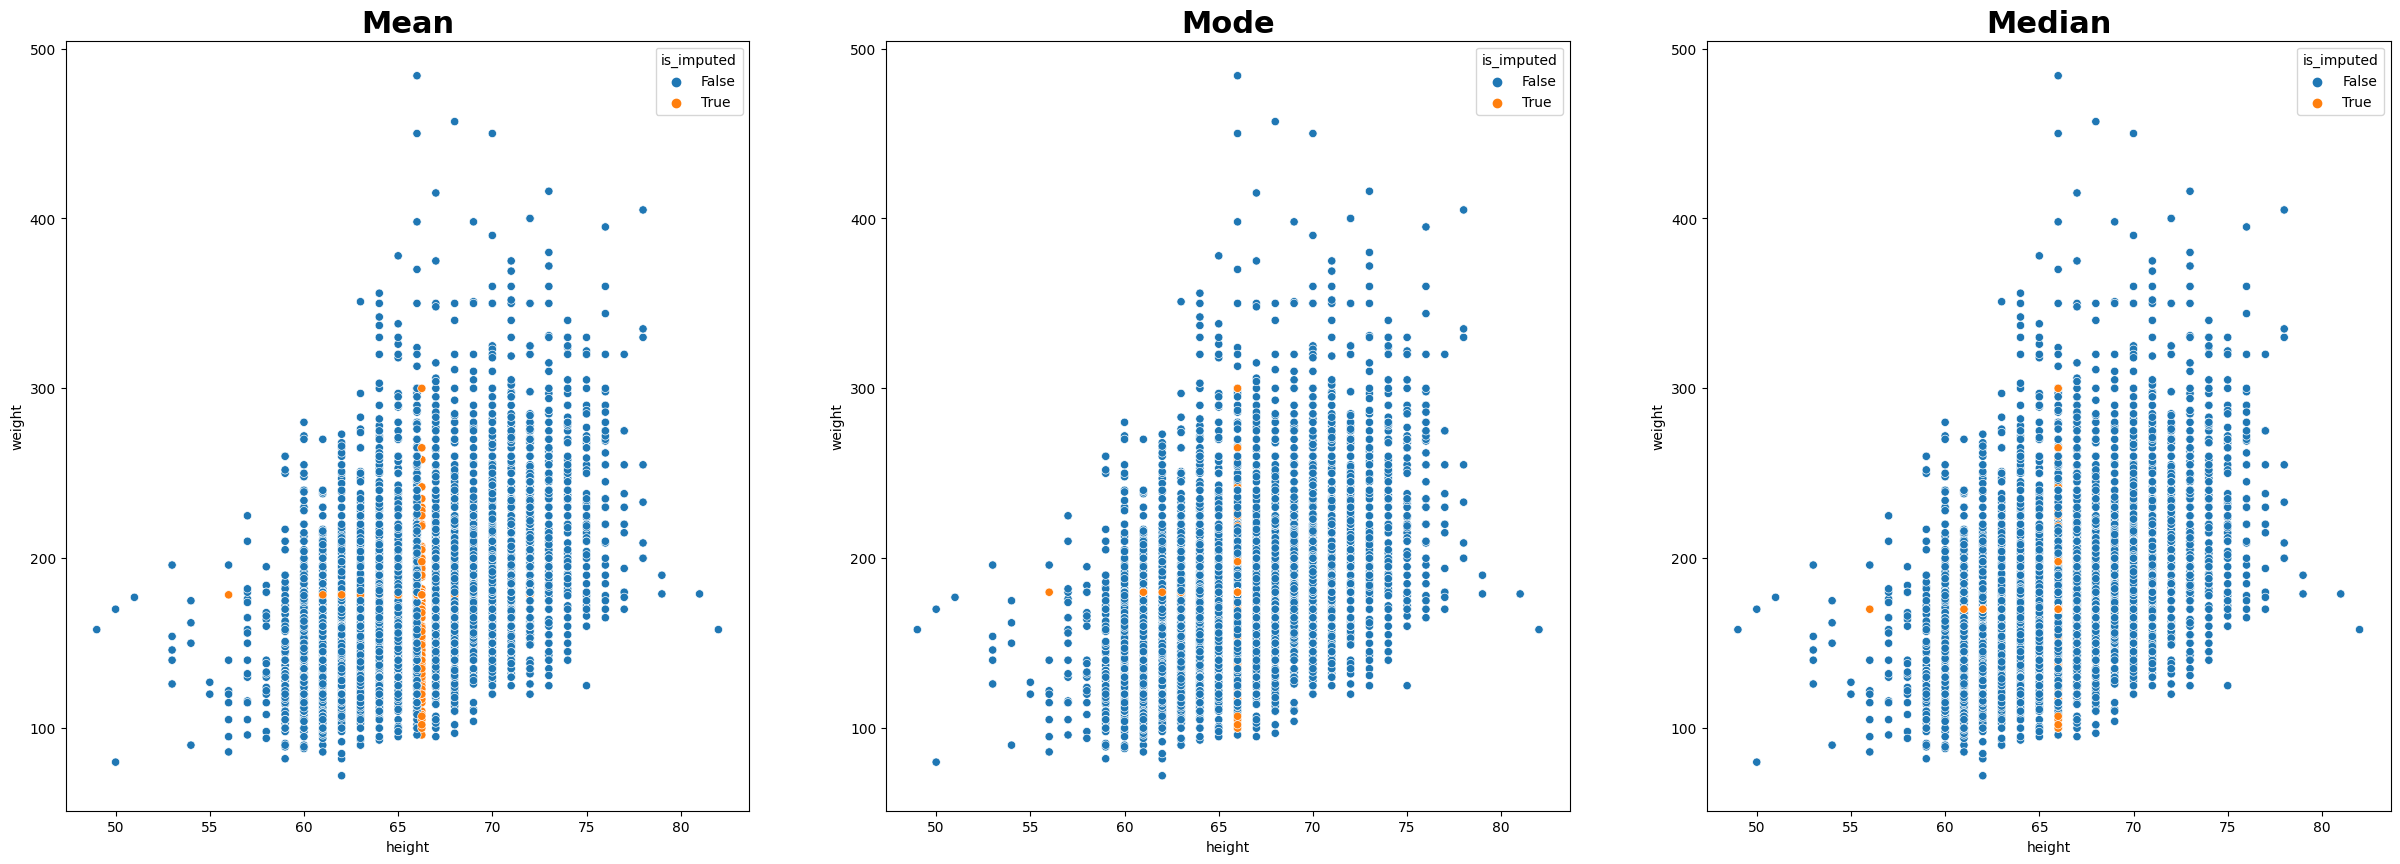

In [95]:
fig, ax = plt.subplots(1,3,figsize=(30,10),sharey=False)



# con la media
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x="height", 
        y="weight", 
        #show_marginal=True, 
        #height=10,
        ax = ax[0]
        )
);

# Con la moda
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()[0]),
        weight = lambda df: df.weight.fillna(value = df.weight.mode()[0])
    )
    .missing.scatter_imputation_plot(
        x="height", 
        y="weight", 
        #show_marginal=True, 
        #height=10,
        ax = ax[1]
        )
);

# Calcularlo con la mediana 
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    )
    .missing.scatter_imputation_plot(
        x="height", 
        y="weight", 
        #show_marginal=True, 
        #height=10,
        ax = ax[2]
        

        )

);

ax[0].set_title("Mean", fontsize =22, fontweight='bold');
ax[2].set_title("Median", fontsize =22, fontweight='bold');
ax[1].set_title("Mode", fontsize =22, fontweight='bold');



## Imputación por llenado hacia atrás y hacia adelante

*Imputación por Llenado Hacia Atrás y Hacia Adelante (Hot Deck y Cold Deck)*

La imputación por llenado hacia atrás y hacia adelante consiste en sustituir los valores faltantes con valores completos que están antes o después en la secuencia de datos.

*Ventajas*

- **Rápido y fácil de implementar**
- Los datos imputados no son constantes, dependen de los valores alrededor (arriba, abajo, a la derecha o a la izquierda).
- Existen trucos para evitar romper las relaciones entre variables.

*Desventajas*

- Las relaciones multivariables pueden ser distorsionadas


### fillna() vs ffill() o bfill()

In [96]:
(
    nhanes_df
    .select_columns("height","weight")
    .fillna(method = "ffill") # ffill para rellenar con los vecinos
    #.ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [97]:
(
    nhanes_df
    .select_columns("height","weight")
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Recomendaciones al imputar valores utilizando ffill() o bfill()</b>
    <br>
    <br>
    <p>
    <ul>
        <li>
            Imputación dentro de dominios e imputación a través de variables correlacionadas
        </li>
    </ul>
    </p>
</div>

In [98]:
nhanes_df.head()

,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


In [99]:
(
    nhanes_df
    .select_columns("gender","height","weight","diebetes","general_health_condition")
    .sort_values(
        by = ["gender","diebetes","general_health_condition","weight"],
        ascending= True
    )
    .transform_column(
        "weight",
        lambda x : x.ffill(),
        elementwise = False
    )
)

,gender,height,weight,diebetes,general_health_condition
SEQN,,,,,
94195.0,Female,63.0,90.0,0,Excellent
95793.0,Female,61.0,96.0,0,Excellent
101420.0,Female,59.0,98.0,0,Excellent
94148.0,Female,65.0,100.0,0,Excellent
102062.0,Female,62.0,100.0,0,Excellent
...,...,...,...,...,...
96561.0,Male,74.0,290.0,1,NaN
96869.0,Male,72.0,298.0,1,NaN
97267.0,Male,NaN,298.0,1,NaN


Muy útil la recomendación a la hora de hacer la imputación hacia adelante organizar por datos o grupos similares, de esta manera los datos reemplazados se parecen a sus semejantes.

## Imputación por interpolación

In [100]:
airquality_df.select_columns("ozone")
                                           

,ozone
date,
1973-05-01,41.0
1973-05-02,36.0
1973-05-03,12.0
1973-05-04,18.0
1973-05-05,NaN
...,...
1973-09-26,30.0
1973-09-27,NaN
1973-09-28,14.0


<Axes: xlabel='date'>

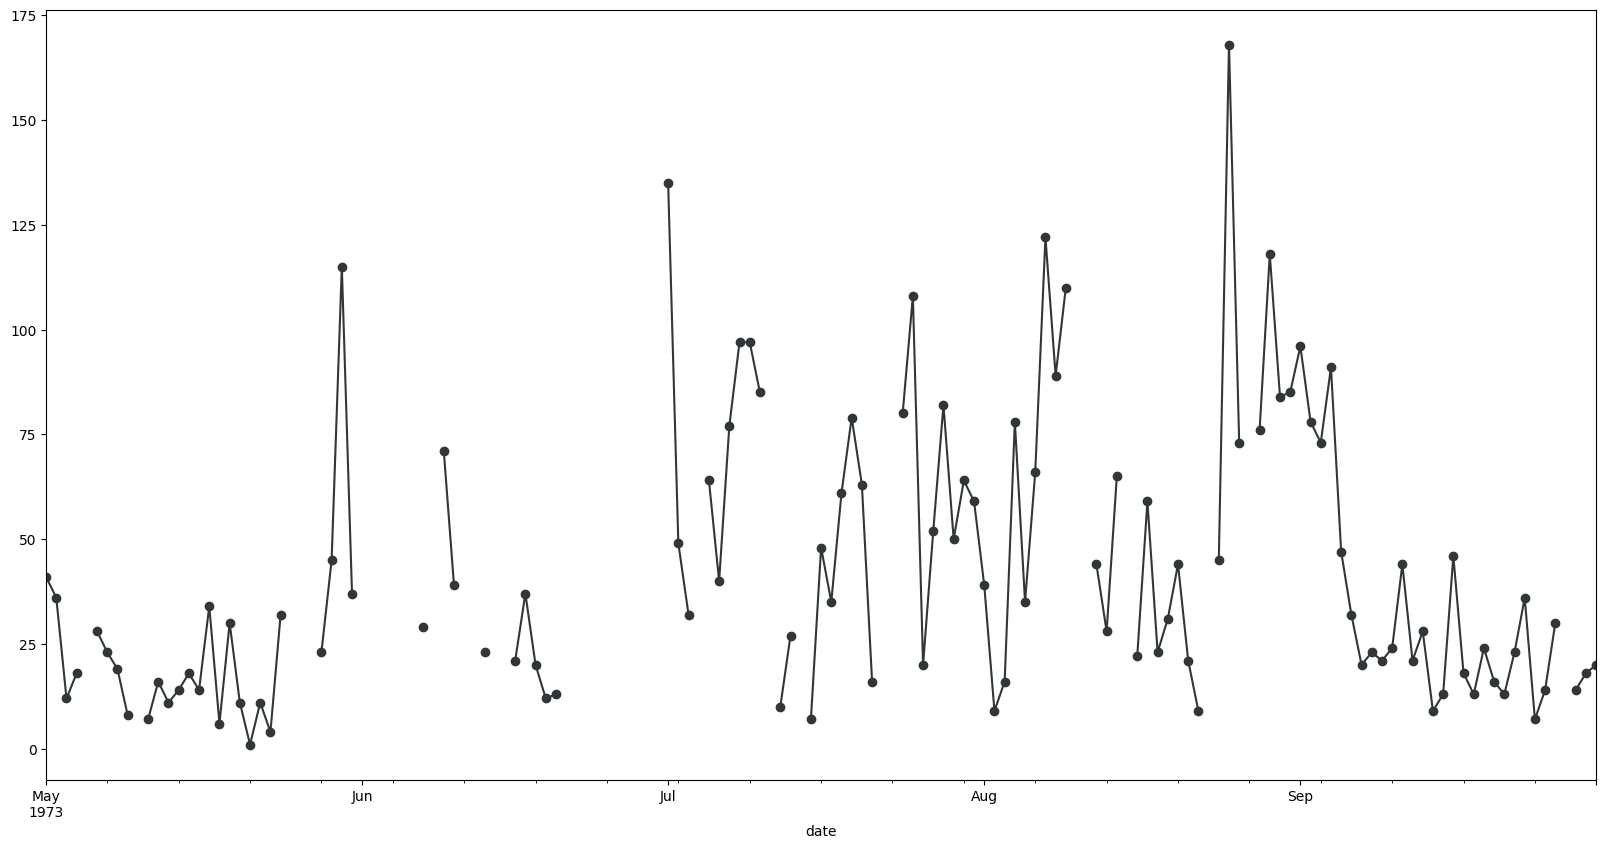

In [101]:

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

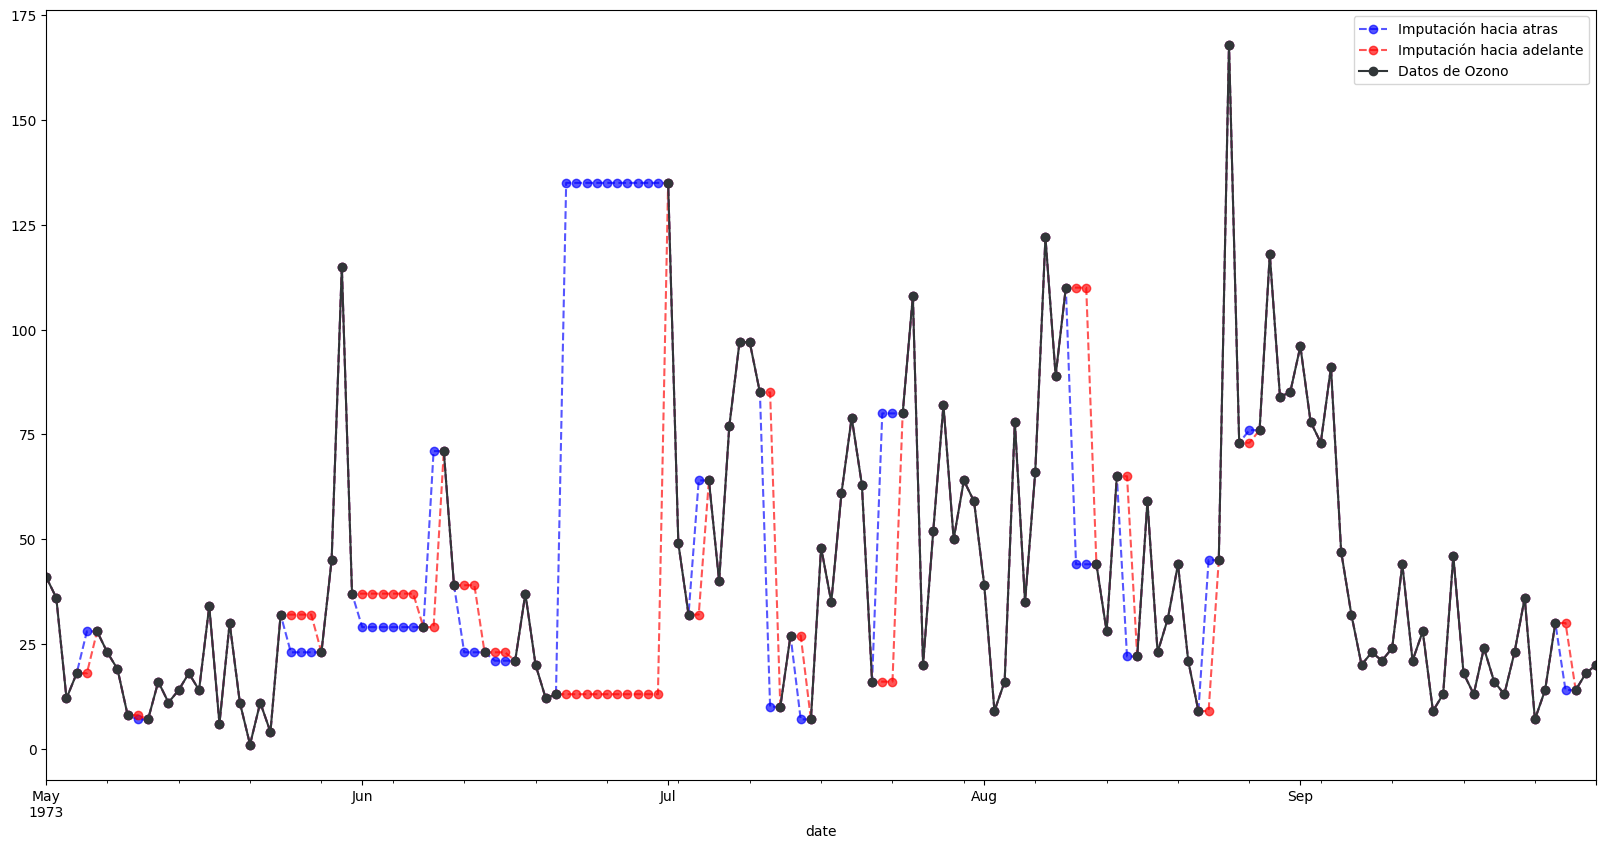

In [102]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color = "blue", marker = "o", alpha=6/9, linestyle = "dashed", label="Imputación hacia atras"),
            df.ozone.ffill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed",label="Imputación hacia adelante"),
            df.ozone.plot(color = "#313638", marker = "o",label="Datos de Ozono")
        )
    )
)
plt.legend()

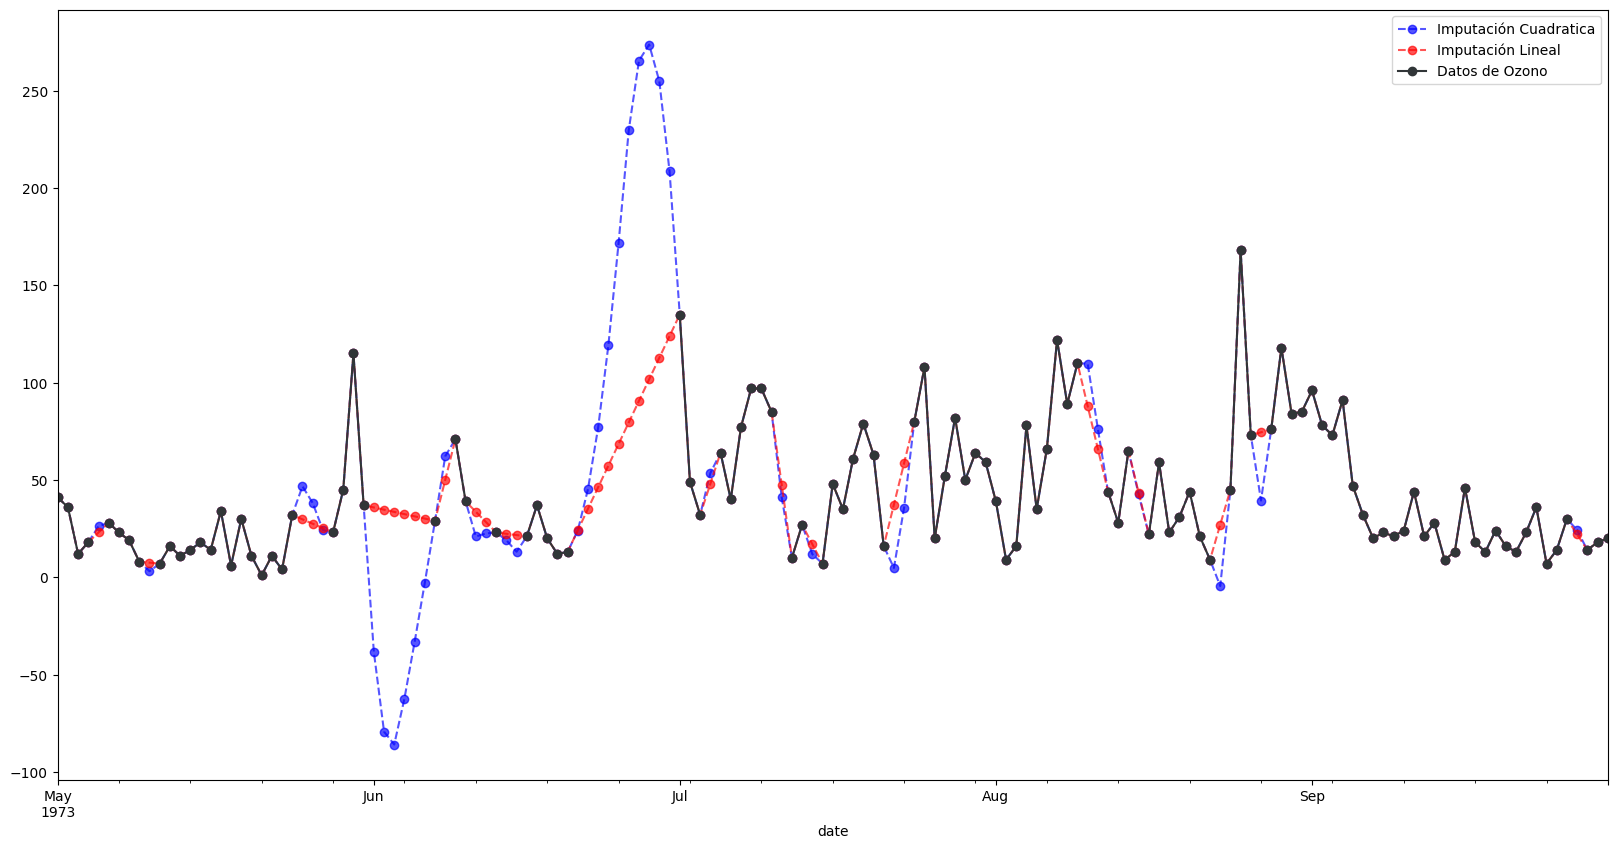

In [103]:

plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            # Usamos el metodo {lineal : "Linear", Cuadratico : "quadratic", Mas_Cercano : "nearest"}
            df.ozone.interpolate(method = "quadratic").plot(color = "blue", marker = "o", alpha=6/9, linestyle = "dashed", label= "Imputación Cuadratica"),
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed",label= "Imputación Lineal"),
            df.ozone.plot(color = "#313638", marker = "o", label = "Datos de Ozono")
        )
    )
)
plt.legend()

### Imputar los datos a la columna

In [104]:
airquality_df["ozone"] = airquality_df.ozone.interpolate(method="linear")

## Imputación por KNN

*Pasos para imputación por k-Nearest-Neighbors*

1. **Para cada observación con valores faltantes:**
    - Encuentra otras K observaciones (donadores, vecinos) que sean más similares a esa observación.
    - Reemplaza los valores faltantes con los valores agregados de los K vecinos.

2. **¿Cómo determinar cuáles son los vecinos más similares?**
    - **Cuantificación de distancia:** Distancia euclidiana útil para variables numéricas.
    - **Distancia Manhattan:** Útil para variables tipo factor.
    - **Distancia de Hamming:** Útil para variables categóricas.
    - **Distancia de Gower:** Útil para conjuntos de datos con variables mixtas.


### Métricas de Distancia para Determinar Vecinos Similares

### Distancia Euclidiana
- Útil para variables numéricas.
- Se traza una línea recta entre dos puntos en un espacio euclidiano.
- La distancia euclidiana se utiliza como parámetro para definir proximidad.



### Distancia Manhattan
- Muy útil para variables de tipo factor (días de la semana, condiciones como lento, rápido).
- Representa la distancia absoluta entre dos puntos.
  


### Distancia de Hamming
- Útil para variables categóricas.
- Cuantifica la diferencia entre textos.



### Distancia de Gower
- Útil para conjuntos de datos con variables mixtas.
- Se define como la distancia de un vecino a otros vecinos para determinar la distancia global referente a la fila que contiene el valor faltante.



### Ventajas
- Sencillo de implementar.
- Buen rendimiento con conjuntos de datos pequeños.
- Excelente para datos numéricos, pero también funciona para datos mixtos.

### Desventajas
- Su escalabilidad puede ser comprometedora dependiendo del número de variables y el tamaño de las observaciones.
- Requiere transformaciones especiales para las variables categóricas, ya que no solo se introducen números y se necesita cuantificar estas distancias.
- Sensibilidad a valores atípicos.


## Imputación por KNN en Python

In [105]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diebetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [106]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [107]:
nhanes_df.iloc[:,:]

,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [124]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diebetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<Axes: xlabel='height', ylabel='weight'>

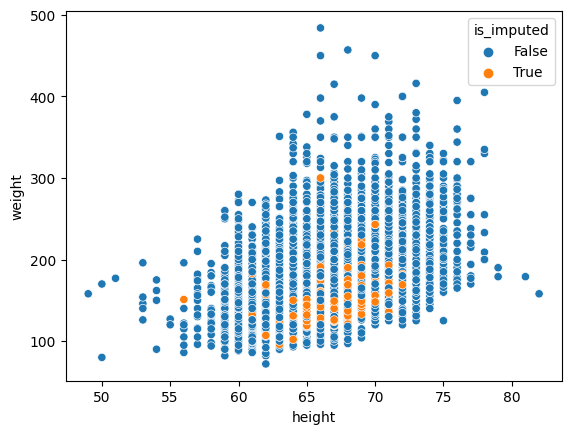

In [109]:

(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x="height", 
        y="weight")
)

### Ordenamiento por cantidad de variables faltantes

<Axes: xlabel='height', ylabel='weight'>

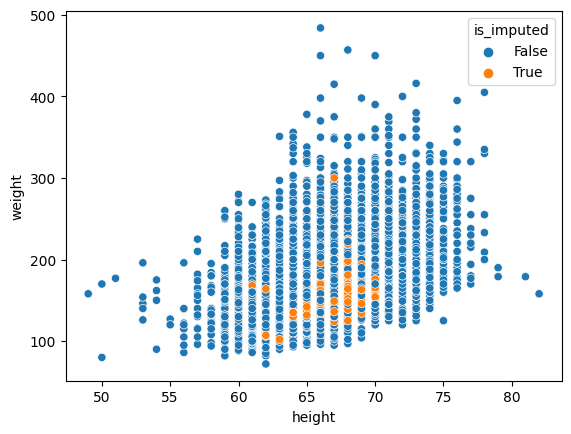

In [110]:

knn_imputer = sklearn.impute.KNNImputer(n_neighbors = 10)

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()

(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

# Imputación basada en modelos


In [111]:

nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values(by = "height")
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix = "_imp",
        #only_missing = True
    )
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [112]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age",  data=df)
    )
    .fit()
)



In [113]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [114]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


<Axes: xlabel='height', ylabel='weight'>

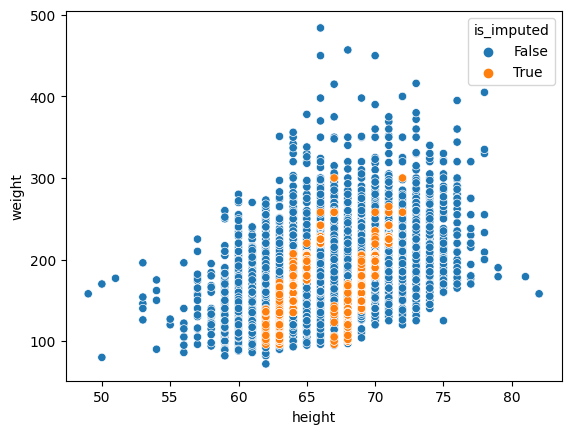

In [115]:

(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)


<Axes: xlabel='height', ylabel='weight'>

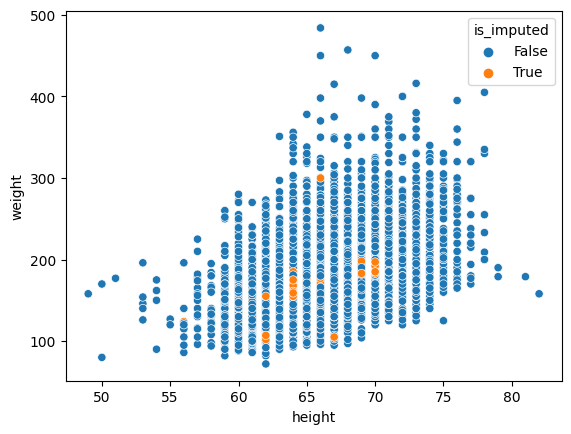

In [116]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())

nhanes_mice_df = nhanes_transformed_df.copy(deep = True)

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_mice_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
    ],
    axis = 1
)

nhanes_mice_df.missing.scatter_imputation_plot(
    x = "height",
    y = "weight"
)

# Conclusión

## Transformación inversa de los datos

In [117]:

nhanes_imputated_df = nhanes_mice_df.copy(deep=True)

nhanes_imputated_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputated_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diebetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False


In [118]:
nhanes_df.general_health_condition.value_counts()

general_health_condition
Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [119]:
nhanes_imputated_df.general_health_condition.value_counts()


general_health_condition
Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [120]:
nhanes_mice_df.missing.number_missing()


0

# Pruebas

In [121]:
nhanes_raw_df.select_columns("*activi*")

,vigorous_work_activity,moderate_work_activity,vigorous_recreational_activities,moderate_recreational_activities,minutes_sedentary_activity
SEQN,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,NaN,NaN,NaN,NaN
93705.0,0.0,0.0,0.0,1.0,300.0
93706.0,0.0,0.0,0.0,1.0,240.0
93707.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
102952.0,0.0,0.0,0.0,1.0,120.0
102953.0,1.0,1.0,0.0,0.0,360.0
102954.0,0.0,0.0,0.0,1.0,600.0
